# Dialysis Prediction using Laboratory Tests

This notebook explores the application of machine learning to predict whether a patient requires dialysis based on routine laboratory test results and demographic features.

### Dataset Note
To ensure patient privacy, the data used in this public repository is **synthetic**. It follows the same structure as the original dataset collected from a hospital in Iran, but the values have been generated randomly.
* The results and metrics shown in this notebook reflect the synthetic data and may not represent the true clinical performance of the model.
* The actual model, trained on the confidential patient data, achieved higher performance metrics due to real clinical correlations not present here.

### Project Workflow
In this notebook, I cover the following steps:

1. **Data Loading:** Importing the synthetic dataset.
2. **Preprocessing:** Cleaning data, handling missing values, and encoding categorical variables.
3. **Exploratory Data Analysis (EDA):** Visualizing distributions and correlations.
4. **Data Splitting:** Stratified train-test split to maintain class ratios.
5. **Handling Imbalance:** Using oversampling techniques to address class imbalance.
6. **Model Training:** Testing baseline models (Logistic Regression, Random Forest, SVM).
7. **Optimization:** Hyperparameter tuning to improve performance.
8. **Evaluation:** Comparing models using accuracy, precision, recall, and ROC-AUC scores.
9. **Interpretation:** Analyzing feature importance to understand which lab tests contribute most to the prediction.

In [1]:
# ==========================================
# 1. Imports
# ==========================================

# Core
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Data cleaning / preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample   # simple oversampling

# Train / test split & CV
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
)

# Dimensionality reduction
from sklearn.decomposition import PCA

# Pipeline
from sklearn.pipeline import Pipeline

print("✅ Imports loaded.")

✅ Imports loaded.


## 2. Data Loading

The dataset consists of two separate Excel files representing the target classes:

* `kidneyFALSE.xlsx`: Data for patients not in the dialysis department.
* `kidneyTRUE.xlsx`: Data for patients in the dialysis department.

The raw data is stored in **long format**, where each row corresponds to a specific lab test (`ServiceName`) for a single patient, rather than one row per patient. In this step, I load both files and concatenate them into a single dataframe to begin processing.

In [2]:
# ==========================================
# 2. Load raw Excel files
# ==========================================

USE_REAL_DATA = False

if USE_REAL_DATA:
    path_true = "data/kidneyTRUE.xlsx"      #this is the REAL data, sadly i wont be sharing it. just syn 
    path_false = "data/kidneyFALSE.xlsx"    #this is the REAL data, sadly i wont be sharing it. just syn 
else:
    path_true = "data/kidney_synthetic.xlsx"
    path_false = "data/kidney_synthetic.xlsx"

raw_true = pd.read_excel(path_true)
raw_false = pd.read_excel(path_false)


raw = pd.concat([raw_true, raw_false], ignore_index=True)
print("Raw shape:", raw.shape)
raw.head()

Raw shape: (42000, 8)


,NationalNo,age,gender,ServiceCode,ServiceName,Answer,ReceptionDate,RequestPartName
0,1,29,مرد,T001,BUN,27.524518,2023-07-02,جراحی عمومی
1,1,29,مرد,T002,Creat,0.414689,2023-05-16,جراحی عمومی
2,1,29,مرد,T003,K,3.679128,2023-03-08,جراحی عمومی
3,1,29,مرد,T004,Phos,3.776704,2023-12-05,جراحی عمومی
4,1,29,مرد,T005,Hb,13.025636,2023-10-13,جراحی عمومی


## 3. Initial Exploration

Before processing the data, I inspect the dataframe structure to understand the available columns and data types. Specifically, I am checking for:

* **Identifiers:** `NationalNo` (to distinguish patients).
* **Demographics:** `age` and `gender`.
* **Lab Data:** `ServiceName` (the type of test) and `Answer` (the result).
* **Metadata:** `RequestPartName` (department or unit info).

In [3]:
# ==========================================
# 3. Inspect raw structure
# ==========================================

raw.columns = raw.columns.str.strip()
print("Columns:")
print(raw.columns.tolist())

print("\nInfo:")
print(raw.info())

raw.head()

Columns:
['NationalNo', 'age', 'gender', 'ServiceCode', 'ServiceName', 'Answer', 'ReceptionDate', 'RequestPartName']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   NationalNo       42000 non-null  int64         
 1   age              42000 non-null  int64         
 2   gender           42000 non-null  object        
 3   ServiceCode      42000 non-null  object        
 4   ServiceName      42000 non-null  object        
 5   Answer           42000 non-null  object        
 6   ReceptionDate    42000 non-null  datetime64[ns]
 7   RequestPartName  42000 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 2.6+ MB
None


,NationalNo,age,gender,ServiceCode,ServiceName,Answer,ReceptionDate,RequestPartName
0,1,29,مرد,T001,BUN,27.524518,2023-07-02,جراحی عمومی
1,1,29,مرد,T002,Creat,0.414689,2023-05-16,جراحی عمومی
2,1,29,مرد,T003,K,3.679128,2023-03-08,جراحی عمومی
3,1,29,مرد,T004,Phos,3.776704,2023-12-05,جراحی عمومی
4,1,29,مرد,T005,Hb,13.025636,2023-10-13,جراحی عمومی


## 4. Data Cleaning and Restructuring

The raw data is currently in a **long format**, meaning each patient corresponds to multiple rows (one for each lab test). For machine learning, we need a **wide format** where each row represents a unique patient.

The target structure includes:
* **Features:** Lab results (e.g., `BUN`, `Creat`, `Hb`) as individual columns.
* **Demographics:** `age` and `gender`.
* **Target:** `Class` (1 for dialysis, 0 for non-dialysis).

**Process:**
I will rename the columns for consistency, pivot the dataframe based on the test name (`ServiceName`), and merge the demographic details back in. Finally, features with a very high percentage of missing values will be dropped.

In [4]:
# ==========================================
# 4.1 Rename important columns + translate Persian ward & gender
# ==========================================

df = raw.copy()

rename_map = {
    "No column name": "gender",        # gender column from the original file
    "RequestPartName": "Class_raw"     # department / ward name (originally partly in Persian)
}

for old, new in rename_map.items():
    if old in df.columns:
        df = df.rename(columns={old: new})

# ------------------------------------------------------------------
# Normalize and translate Persian ward names in Class_raw to English
# ------------------------------------------------------------------
if "Class_raw" in df.columns:
    # Clean spaces
    df["Class_raw"] = df["Class_raw"].astype(str).str.strip()

    ward_translation = {
        "دياليز": "Dialysis",
        "IPD": "IPD",
        "ICU": "ICU",
        "بخش جراحي": "Surgery Ward",
        "بخش اورژانس": "Emergency Ward",
        "بلوک زايمان": "Labor & Delivery Ward",
        "زنان و زايمان": "Obstetrics & Gynecology Ward",
        "بخش داخلي": "Internal Medicine Ward",
        "-": "Unknown Ward",
        "اورژانس": "Emergency",
        "بخش جنرال": "General Ward",
        "CCU2": "CCU2",
        "اتاق عمل": "Operating Room",
        "اطفال": "Pediatrics Ward",
        "جراحي اكسترا": "Extra Surgery Ward",
    }

    df["Class_raw"] = df["Class_raw"].replace(ward_translation)

# ------------------------------------------------------------------
# Normalize and translate Persian gender values to English
# ------------------------------------------------------------------
if "gender" in df.columns:
    df["gender"] = df["gender"].astype(str).str.strip()

    gender_translation = {
        "مرد": "Male",
        "زن": "Female",
    }

    df["gender"] = df["gender"].replace(gender_translation)

print("Columns after renaming & translation:")
print(df.columns.tolist())
if "Class_raw" in df.columns:
    print("Sample Class_raw values after translation:")
    print(df["Class_raw"].dropna().unique()[:20])
if "gender" in df.columns:
    print("Gender values after translation:")
    print(df["gender"].dropna().unique())


Columns after renaming & translation:
['NationalNo', 'age', 'gender', 'ServiceCode', 'ServiceName', 'Answer', 'ReceptionDate', 'Class_raw']
Sample Class_raw values after translation:
['جراحی عمومی' 'Emergency' 'Dialysis' 'داخلی' 'قلب']
Gender values after translation:
['Male' 'Female']


In [5]:
# ==========================================
# 4.2 Pivot: long -> wide by ServiceName
# ==========================================

id_cols = [c for c in ["NationalNo", "age", "gender", "Class_raw"] if c in df.columns]

wide = df.pivot_table(
    index=id_cols,
    columns="ServiceName",
    values="Answer",
    aggfunc="first"
).reset_index()

# Flatten columns in case of MultiIndex
wide.columns = [str(c) for c in wide.columns]

print("Shape after pivot:", wide.shape)
wide.head()

Shape after pivot: (3000, 11)


,NationalNo,age,gender,Class_raw,BUN,Creat,Hb,K,Phos,Protein,Urine Protein 24 hrs
0,1,29,Male,جراحی عمومی,27.524518,0.414689,13.025636,3.679128,3.776704,trace,4.42929
1,2,32,Female,Emergency,12.328939,1.263535,12.478606,4.18003,3.589083,1+,10.546341
2,3,61,Female,Dialysis,112.832952,4.890377,11.231959,4.84143,4.523473,2+,65.195039
3,4,53,Female,جراحی عمومی,21.857291,1.035006,13.835393,4.287475,4.222857,neg,7.208346
4,5,35,Female,Emergency,31.95953,0.740251,12.997672,4.587311,2.690278,trace,5.022497


### 4.3 Data Type Conversion and Feature Selection

Lab results in the raw dataset sometimes contain text strings (e.g., "Trace", "Neg") alongside numerical values. To prepare the data for machine learning, I convert all lab test columns to numeric types. Any non-numeric values are coerced to `NaN`.

Following this, I calculate the missingness ratio for each column. Features with more than **80% missing values** are dropped to reduce noise and dimensionality.

In [6]:
# ==========================================
# 4.3 Numeric conversion & high-missing drop
# ==========================================

dfw = wide.copy()

id_cols = [c for c in ["NationalNo", "age", "gender", "Class_raw"] if c in dfw.columns]
feature_cols = [c for c in dfw.columns if c not in id_cols]

# Convert lab/value columns to numeric where possible (non-numeric -> NaN)
for col in feature_cols:
    dfw[col] = pd.to_numeric(dfw[col], errors="coerce")

missing_pct = dfw.isna().mean() * 100
print("Missing percentages (top 20):")
print(missing_pct.sort_values(ascending=False).head(20))

# We only drop columns that are basically completely unusable:
# >= 99% missing values.
threshold = 99.0  # percent
cols_to_drop = missing_pct[missing_pct >= threshold].index.tolist()
print("\nDropping columns with >= 99% missing:")
print(cols_to_drop)

dfw = dfw.drop(columns=cols_to_drop)
print("\nNew shape:", dfw.shape)
dfw.head()


Missing percentages (top 20):
Protein                 100.0
age                       0.0
NationalNo                0.0
gender                    0.0
Class_raw                 0.0
Creat                     0.0
BUN                       0.0
Hb                        0.0
K                         0.0
Phos                      0.0
Urine Protein 24 hrs      0.0
dtype: float64

Dropping columns with >= 99% missing:
['Protein']

New shape: (3000, 10)


,NationalNo,age,gender,Class_raw,BUN,Creat,Hb,K,Phos,Urine Protein 24 hrs
0,1,29,Male,جراحی عمومی,27.524518,0.414689,13.025636,3.679128,3.776704,4.429290
1,2,32,Female,Emergency,12.328939,1.263535,12.478606,4.180030,3.589083,10.546341
2,3,61,Female,Dialysis,112.832952,4.890377,11.231959,4.841430,4.523473,65.195039
3,4,53,Female,جراحی عمومی,21.857291,1.035006,13.835393,4.287475,4.222857,7.208346
4,5,35,Female,Emergency,31.959530,0.740251,12.997672,4.587311,2.690278,5.022497


## 5. Target Variable Definition

I create the binary target variable, `Class`, based on the department name found in `Class_raw`.

* **1 (Positive):** If the department name contains "دياليز" (Dialysis).
* **0 (Negative):** All other departments.

The `gender` column is retained as a categorical feature and will be encoded during the pipeline setup.

In [7]:
# ==========================================
# 5. Target definition (dialysis vs non-dialysis)
# ==========================================

# Make sure Class_raw is string and cleaned
dfw["Class_raw"] = dfw["Class_raw"].astype(str).str.strip()

# New binary target:
# 1 = rows where Class_raw contains "Dialysis" (dialysis ward)
# 0 = everyone else (not dialysis / not kidney problem)
dfw["Class"] = dfw["Class_raw"].str.contains("Dialysis", na=False).astype(int)

print("Target distribution:")
print(dfw["Class"].value_counts())
dfw[["Class_raw", "Class"]].head(10)


Target distribution:
Class
0    1964
1    1036
Name: count, dtype: int64


,Class_raw,Class
0,جراحی عمومی,0
1,Emergency,0
2,Dialysis,1
3,جراحی عمومی,0
4,Emergency,0
5,داخلی,0
6,Dialysis,1
7,داخلی,0
8,Emergency,0
9,Emergency,0


### Dropping Identifiers

I remove the `NationalNo` (Patient ID) column. Unique identifiers do not carry any predictive information, and keeping them could lead to the model memorizing specific patients rather than learning generalizable patterns (overfitting).

In [8]:
# ==========================================
# 5.2 Drop identifiers
# ==========================================

for col in ["NationalNo"]:
    if col in dfw.columns:
        dfw = dfw.drop(columns=col)

print("Columns now:")
print(dfw.columns.tolist())

Columns now:
['age', 'gender', 'Class_raw', 'BUN', 'Creat', 'Hb', 'K', 'Phos', 'Urine Protein 24 hrs', 'Class']


## 6. Imputation of Missing Values

I separate the dataset into numerical and categorical columns to apply specific imputation strategies:

* **Numeric columns (e.g., Lab values, Age):** Missing values are filled using the **median**. The median is chosen to reduce the influence of outliers, which are common in medical data.
* **Categorical columns (e.g., Gender):** Missing values are filled using the **most frequent** value (mode).

In [9]:
# ==========================================
# 6. Impute missing values
# ==========================================

# Separate numeric and categorical columns
num_cols = [c for c in dfw.select_dtypes(include=["number"]).columns if c != "Class"]
cat_cols = [c for c in dfw.select_dtypes(exclude=["number"]).columns]

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# Numeric imputation
num_imputer = SimpleImputer(strategy="median")
dfw[num_cols] = num_imputer.fit_transform(dfw[num_cols])

# Categorical imputation (if any)
if cat_cols:
    cat_imputer = SimpleImputer(strategy="most_frequent")
    dfw[cat_cols] = cat_imputer.fit_transform(dfw[cat_cols])

print("\nMissing % after imputation:")
print((dfw.isna().mean() * 100).sort_values(ascending=False).head(10))

Numeric columns: ['age', 'BUN', 'Creat', 'Hb', 'K', 'Phos', 'Urine Protein 24 hrs']
Categorical columns: ['gender', 'Class_raw']

Missing % after imputation:
age                     0.0
gender                  0.0
Class_raw               0.0
BUN                     0.0
Creat                   0.0
Hb                      0.0
K                       0.0
Phos                    0.0
Urine Protein 24 hrs    0.0
Class                   0.0
dtype: float64


## 7. Feature Engineering

To improve the model's ability to detect patterns, I created a new feature based on clinical domain knowledge: the **BUN/Creatinine Ratio**.

* **Formula:** $BUN \div Creatinine$
* **Reasoning:** This ratio is a standard metric in nephrology used to differentiate between pre-renal and intrinsic kidney failure. Including it allows the model to utilize the relationship between these two variables explicitly, rather than relying on the model to infer it.

In [10]:
# ==========================================
# 7. Feature engineering
# ==========================================

df_fe = dfw.copy()

if "BUN" in df_fe.columns and "Creat" in df_fe.columns:
    df_fe["BUN_Creat_ratio"] = df_fe["BUN"] / (df_fe["Creat"] + 1e-6)

# You can add more domain-inspired ratios here if meaningful.

print("New columns added (if any):")
new_cols = set(df_fe.columns) - set(dfw.columns)
print(new_cols)

df_fe.head()

New columns added (if any):
{'BUN_Creat_ratio'}


,age,gender,Class_raw,BUN,Creat,Hb,K,Phos,Urine Protein 24 hrs,Class,BUN_Creat_ratio
0,29.0,Male,جراحی عمومی,27.524518,0.414689,13.025636,3.679128,3.776704,4.429290,0,66.373649
1,32.0,Female,Emergency,12.328939,1.263535,12.478606,4.180030,3.589083,10.546341,0,9.757489
2,61.0,Female,Dialysis,112.832952,4.890377,11.231959,4.841430,4.523473,65.195039,1,23.072438
3,53.0,Female,جراحی عمومی,21.857291,1.035006,13.835393,4.287475,4.222857,7.208346,0,21.118018
4,35.0,Female,Emergency,31.959530,0.740251,12.997672,4.587311,2.690278,5.022497,0,43.173872


## 8. One-Hot Encoding

Machine learning models require numerical input. To handle the categorical `gender` variable, I apply one-hot encoding. This converts the column into binary indicator variables (e.g., `gender_M`, `gender_F`), allowing the algorithms to interpret the data correctly without assuming an ordinal relationship.

In [11]:
# ==========================================
# 8. One-hot encode gender
# ==========================================

df = df_fe.copy()

if "gender" in df.columns:
    df = pd.get_dummies(df, columns=["gender"], drop_first=False)
    print("Columns after one-hot encoding gender:")
    print([c for c in df.columns if c.startswith("gender_")])
else:
    print("No 'gender' column found, skipping one-hot encoding.")

df.head()

Columns after one-hot encoding gender:
['gender_Female', 'gender_Male']


,age,Class_raw,BUN,Creat,Hb,K,Phos,Urine Protein 24 hrs,Class,BUN_Creat_ratio,gender_Female,gender_Male
0,29.0,جراحی عمومی,27.524518,0.414689,13.025636,3.679128,3.776704,4.429290,0,66.373649,False,True
1,32.0,Emergency,12.328939,1.263535,12.478606,4.180030,3.589083,10.546341,0,9.757489,True,False
2,61.0,Dialysis,112.832952,4.890377,11.231959,4.841430,4.523473,65.195039,1,23.072438,True,False
3,53.0,جراحی عمومی,21.857291,1.035006,13.835393,4.287475,4.222857,7.208346,0,21.118018,True,False
4,35.0,Emergency,31.959530,0.740251,12.997672,4.587311,2.690278,5.022497,0,43.173872,True,False


## 9. Train-Test Split

I separate the dataset into the feature matrix (`X`) and the target vector (`y`).

To create the training and testing sets, I use a **stratified split**. This is crucial for this dataset because the classes are likely imbalanced. Stratification ensures that the ratio of positive cases (dialysis) to negative cases remains consistent across both the training and testing data. The test set is set aside and will only be used for the final evaluation to prevent data leakage.

In [12]:
# ==========================================
# 9. Train–test split
# ==========================================

if "Class" not in df.columns:
    raise ValueError("Target column 'Class' not found.")

# Drop target + obvious leakage columns from features
leak_cols = [c for c in ["Class", "Class_raw", "NationalNo"] if c in df.columns]

X = df.drop(columns=leak_cols)
y = df["Class"]

print("Feature count:", X.shape[1])

print("\nTarget distribution (overall):")
print(y.value_counts())

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("\nTrain target distribution:")
print(y_train.value_counts())
print("\nTest target distribution:")
print(y_test.value_counts())


Feature count: 10

Target distribution (overall):
Class
0    1964
1    1036
Name: count, dtype: int64

Train target distribution:
Class
0    1571
1     829
Name: count, dtype: int64

Test target distribution:
Class
0    393
1    207
Name: count, dtype: int64


## 10. Handling Class Imbalance

The dataset exhibits significant class imbalance, with far fewer dialysis patients than non-dialysis patients. If left unaddressed, the model might bias itself toward the majority class, achieving high accuracy but failing to identify actual dialysis cases.

To mitigate this, I apply **random oversampling** (bootstrap resampling) to the minority class.

**Important:** Oversampling is applied **only to the training set**. The test set is left in its original state to ensure that the evaluation metrics reflect the model's performance on realistic, imbalanced data.

In [13]:
# ==========================================
# 10. Oversample ONLY the training set
# ==========================================

train_df = pd.concat([X_train, y_train], axis=1)

train_majority = train_df[train_df["Class"] == 0]
train_minority = train_df[train_df["Class"] == 1]

train_minority_upsampled = resample(
    train_minority,
    replace=True,
    n_samples=len(train_majority),
    random_state=42
)

train_resampled = pd.concat(
    [train_majority, train_minority_upsampled],
    ignore_index=True
).sample(frac=1, random_state=42).reset_index(drop=True)

X_train_res = train_resampled.drop(columns=["Class"])
y_train_res = train_resampled["Class"]

print("Train distribution BEFORE oversampling:")
print(y_train.value_counts())
print("\nTrain distribution AFTER oversampling:")
print(y_train_res.value_counts())
print("\nTest distribution (unchanged):")
print(y_test.value_counts())

Train distribution BEFORE oversampling:
Class
0    1571
1     829
Name: count, dtype: int64

Train distribution AFTER oversampling:
Class
1    1571
0    1571
Name: count, dtype: int64

Test distribution (unchanged):
Class
0    393
1    207
Name: count, dtype: int64


## 11. Baseline models

We start with three baseline algorithms:

- **Logistic Regression (LR)** – interpretable linear model  
- **Random Forest (RF)** – ensemble of decision trees  
- **Support Vector Machine (SVM)** with RBF kernel – powerful nonlinear model

Each model is wrapped in a **Pipeline** with `StandardScaler` where appropriate.
We fit on the **oversampled training set** and evaluate on the **original test set**.

BASELINE MODEL: LogisticRegression
Accuracy : 1.000
Precision: 1.000
Recall   : 1.000
F1-score : 1.000
ROC-AUC  : 1.000

Confusion matrix:
[[393   0]
 [  0 207]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       393
           1       1.00      1.00      1.00       207

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



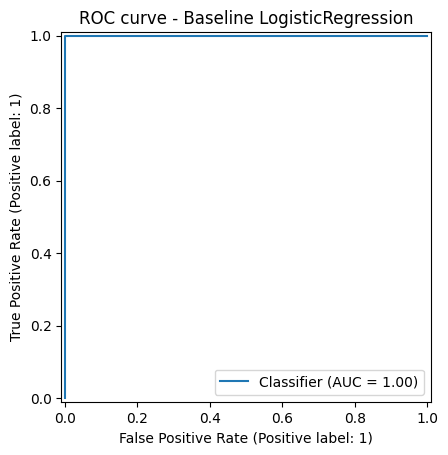

BASELINE MODEL: RandomForest
Accuracy : 0.998
Precision: 1.000
Recall   : 0.995
F1-score : 0.998
ROC-AUC  : 1.000

Confusion matrix:
[[393   0]
 [  1 206]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       393
           1       1.00      1.00      1.00       207

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



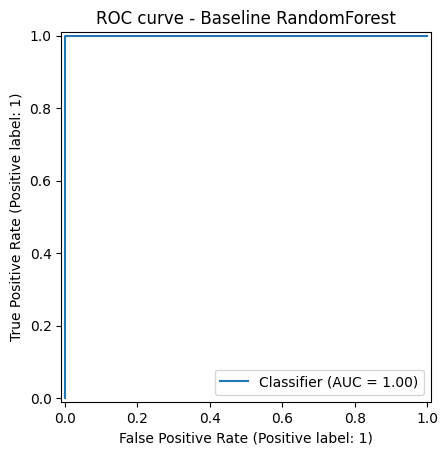

BASELINE MODEL: SVM
Accuracy : 1.000
Precision: 1.000
Recall   : 1.000
F1-score : 1.000
ROC-AUC  : 1.000

Confusion matrix:
[[393   0]
 [  0 207]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       393
           1       1.00      1.00      1.00       207

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



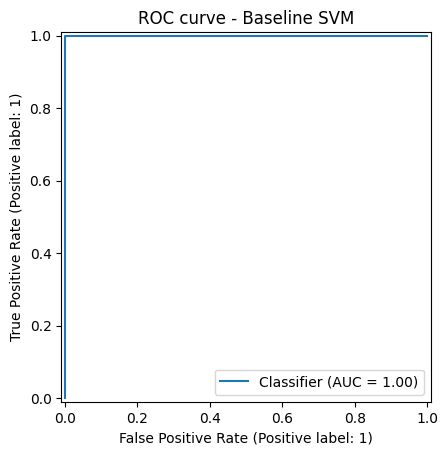


Baseline summary:
                    accuracy  precision    recall        f1  roc_auc
LogisticRegression  1.000000        1.0  1.000000  1.000000      1.0
RandomForest        0.998333        1.0  0.995169  0.997579      1.0
SVM                 1.000000        1.0  1.000000  1.000000      1.0


In [14]:
# ==========================================
# 11. Baseline models (FIXED)
# ==========================================

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# ------------------------------------------------------
# Identify numeric + categorical columns automatically
# ------------------------------------------------------
numeric_features = X_train_res.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train_res.select_dtypes(include=["object", "category"]).columns

# ------------------------------------------------------
# Preprocessing for numeric & categorical columns
# ------------------------------------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # handles "-"
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# ------------------------------------------------------
# Baseline models WITH preprocessing inside the pipeline
# ------------------------------------------------------
baseline_models = {
    "LogisticRegression": Pipeline([
        ("preprocessor", preprocessor),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "RandomForest": Pipeline([
        ("preprocessor", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        ))
    ]),
    "SVM": Pipeline([
        ("preprocessor", preprocessor),
        ("clf", SVC(kernel="rbf", probability=True, random_state=42))
    ]),
}

# ------------------------------------------------------
# Evaluation Loop (unchanged)
# ------------------------------------------------------
baseline_results = {}

for name, model in baseline_models.items():
    print("=" * 60)
    print(f"BASELINE MODEL: {name}")
    print("=" * 60)

    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    auc  = roc_auc_score(y_test, y_proba)

    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-score : {f1:.3f}")
    print(f"ROC-AUC  : {auc:.3f}")

    print("\nConfusion matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    baseline_results[name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc,
    }

    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC curve - Baseline {name}")
    plt.show()

print("\nBaseline summary:")
print(pd.DataFrame(baseline_results).T)


## 12. Hyperparameter tuning

We now **fine‑tune** LR, RF, and SVM using:

- **GridSearchCV** – exhaustive search over a small, carefully chosen grid  
- **RandomizedSearchCV** – randomized search over a wider space within a budget `n_iter`

We use **StratifiedKFold** cross‑validation to preserve class balance in each fold.
All tuning is performed on the **oversampled training set**.

### 12.1 Logistic Regression – GridSearchCV & RandomizedSearchCV

In [15]:
# ==========================================
# 12.1 Logistic Regression tuning (FIXED)
# ==========================================

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# log_reg_pipeline now uses the preprocessor that handles numeric + categorical features
log_reg_pipeline = Pipeline([
    ("preprocessor", preprocessor),  # <-- reuse the ColumnTransformer from before
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

log_reg_param_grid = {
    "clf__C": [0.01, 0.1, 1, 10, 100],
    "clf__penalty": ["l2"],
    "clf__class_weight": [None, "balanced"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

log_reg_grid = GridSearchCV(
    estimator=log_reg_pipeline,
    param_grid=log_reg_param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

log_reg_grid.fit(X_train_res, y_train_res)

print("Best params (LR – GridSearch):", log_reg_grid.best_params_)
print("Best CV AUC:", log_reg_grid.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params (LR – GridSearch): {'clf__C': 0.01, 'clf__class_weight': None, 'clf__penalty': 'l2'}
Best CV AUC: 1.0


In [16]:
# RandomizedSearch for Logistic Regression (wider C range)

log_reg_param_dist = {
    "clf__C": np.logspace(-4, 4, 50),
    "clf__penalty": ["l2"],
    "clf__class_weight": [None, "balanced"],
}

log_reg_random = RandomizedSearchCV(
    estimator=log_reg_pipeline,
    param_distributions=log_reg_param_dist,
    n_iter=25,
    scoring="roc_auc",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

log_reg_random.fit(X_train_res, y_train_res)

print("Best params (LR – RandomizedSearch):", log_reg_random.best_params_)
print("Best CV AUC:", log_reg_random.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best params (LR – RandomizedSearch): {'clf__penalty': 'l2', 'clf__class_weight': 'balanced', 'clf__C': np.float64(494.1713361323828)}
Best CV AUC: 1.0


### 12.2 Random Forest – RandomizedSearchCV then GridSearchCV

In [17]:
# ==========================================
# 12.2 Random Forest tuning (FIXED)
# ==========================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

# Pipeline with the same preprocessor used in the baselines
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),   # ColumnTransformer defined earlier
    ("clf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

rf_param_dist = {
    "clf__n_estimators": np.arange(100, 501, 50),
    "clf__max_depth": [None, 3, 5, 7, 9, 12],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2", None],
    "clf__class_weight": [None, "balanced"]
}

rf_random = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_dist,
    n_iter=40,
    scoring="roc_auc",
    cv=cv,                 # same StratifiedKFold as before
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_random.fit(X_train_res, y_train_res)

print("Best params (RF – RandomizedSearch):", rf_random.best_params_)
print("Best CV AUC:", rf_random.best_score_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params (RF – RandomizedSearch): {'clf__n_estimators': np.int64(150), 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 4, 'clf__max_features': 'sqrt', 'clf__max_depth': 5, 'clf__class_weight': 'balanced'}
Best CV AUC: 1.0


In [18]:
# Optional narrower GridSearch around best RF params

best_rf_params = rf_random.best_params_

rf_param_grid = {
    "clf__n_estimators": [best_rf_params["clf__n_estimators"] - 50,
                          best_rf_params["clf__n_estimators"],
                          best_rf_params["clf__n_estimators"] + 50],
    "clf__max_depth": [best_rf_params["clf__max_depth"]],
    "clf__min_samples_split": [best_rf_params["clf__min_samples_split"]],
    "clf__min_samples_leaf": [best_rf_params["clf__min_samples_leaf"]],
    "clf__max_features": [best_rf_params["clf__max_features"]],
    "clf__class_weight": [best_rf_params["clf__class_weight"]],
}

# Remove any invalid (e.g., non-positive n_estimators)
rf_param_grid["clf__n_estimators"] = [
    n for n in rf_param_grid["clf__n_estimators"] if n > 0
]

rf_grid = GridSearchCV(
    estimator=rf_pipeline,      # same pipeline as in RandomizedSearchCV
    param_grid=rf_param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train_res, y_train_res)

print("Best params (RF – GridSearch around random best):", rf_grid.best_params_)
print("Best CV AUC:", rf_grid.best_score_)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params (RF – GridSearch around random best): {'clf__class_weight': 'balanced', 'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 5, 'clf__n_estimators': np.int64(100)}
Best CV AUC: 1.0


### 12.3 SVM (RBF kernel) – RandomizedSearchCV & GridSearchCV

In [19]:
# ==========================================
# 12.3 SVM tuning
# ==========================================

svm_pipeline = Pipeline([
    ("preprocessor", preprocessor),  # use the same ColumnTransformer as RF/logreg
    ("clf", SVC(kernel="rbf", probability=True, random_state=42))
])

svm_param_dist = {
    "clf__C": np.logspace(-3, 3, 20),
    "clf__gamma": np.logspace(-3, 1, 20),
    "clf__class_weight": [None, "balanced"]
}

svm_random = RandomizedSearchCV(
    estimator=svm_pipeline,
    param_distributions=svm_param_dist,
    n_iter=40,
    scoring="roc_auc",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

svm_random.fit(X_train_res, y_train_res)

print("Best params (SVM – RandomizedSearch):", svm_random.best_params_)
print("Best CV AUC:", svm_random.best_score_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params (SVM – RandomizedSearch): {'clf__gamma': np.float64(0.029763514416313176), 'clf__class_weight': 'balanced', 'clf__C': np.float64(112.88378916846884)}
Best CV AUC: 1.0


In [20]:
# Narrow GridSearch around best SVM params

best_svm_params = svm_random.best_params_

# Example: small grid around the best C and gamma (log-space neighbors)
C_center = best_svm_params["clf__C"]
gamma_center = best_svm_params["clf__gamma"]

C_grid = sorted(set([C_center / 3, C_center, C_center * 3]))
gamma_grid = sorted(set([gamma_center / 3, gamma_center, gamma_center * 3]))

svm_param_grid = {
    "clf__C": C_grid,
    "clf__gamma": gamma_grid,
    "clf__class_weight": [best_svm_params["clf__class_weight"]],
}

svm_grid = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(X_train_res, y_train_res)

print("Best params (SVM – GridSearch around random best):", svm_grid.best_params_)
print("Best CV AUC:", svm_grid.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params (SVM – GridSearch around random best): {'clf__C': np.float64(37.62792972282295), 'clf__class_weight': 'balanced', 'clf__gamma': np.float64(0.009921171472104392)}
Best CV AUC: 1.0


## 13. Final evaluation of tuned models

We now evaluate the **best tuned versions** of LR, RF, and SVM on the **held‑out test set** and compare them.

TUNED MODEL: LogisticRegression_tuned
Accuracy : 1.000
Precision: 1.000
Recall   : 1.000
F1-score : 1.000
ROC-AUC  : 1.000

Confusion matrix:
[[393   0]
 [  0 207]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       393
           1       1.00      1.00      1.00       207

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



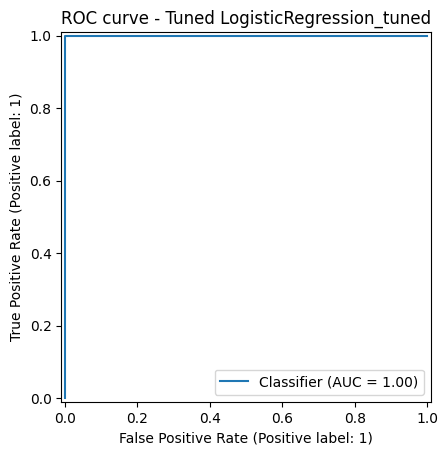

TUNED MODEL: RandomForest_tuned
Accuracy : 0.998
Precision: 1.000
Recall   : 0.995
F1-score : 0.998
ROC-AUC  : 1.000

Confusion matrix:
[[393   0]
 [  1 206]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       393
           1       1.00      1.00      1.00       207

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



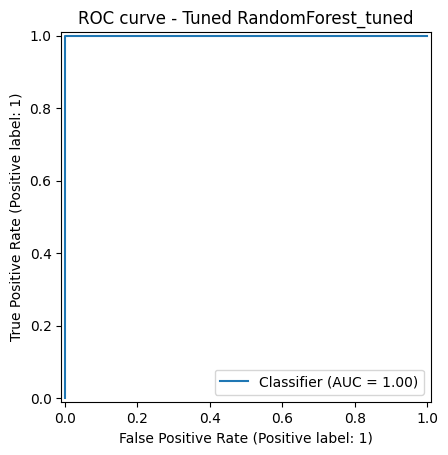

TUNED MODEL: SVM_tuned
Accuracy : 1.000
Precision: 1.000
Recall   : 1.000
F1-score : 1.000
ROC-AUC  : 1.000

Confusion matrix:
[[393   0]
 [  0 207]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       393
           1       1.00      1.00      1.00       207

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



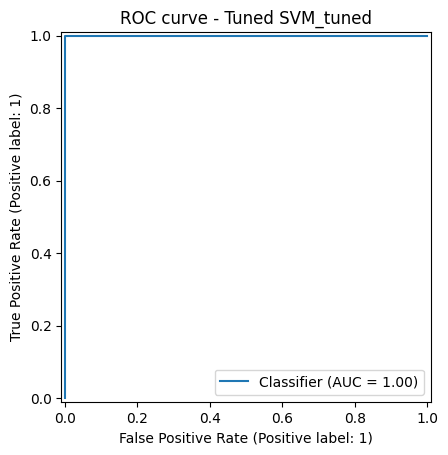


Tuned model summary:
                          accuracy  precision    recall        f1  roc_auc
LogisticRegression_tuned  1.000000        1.0  1.000000  1.000000      1.0
RandomForest_tuned        0.998333        1.0  0.995169  0.997579      1.0
SVM_tuned                 1.000000        1.0  1.000000  1.000000      1.0


In [21]:
# ==========================================
# 13. Evaluate tuned models on test set
# ==========================================

tuned_models = {
    "LogisticRegression_tuned": log_reg_random.best_estimator_,
    "RandomForest_tuned": rf_grid.best_estimator_,
    "SVM_tuned": svm_grid.best_estimator_,
}

tuned_results = {}

for name, model in tuned_models.items():
    print("=" * 60)
    print(f"TUNED MODEL: {name}")
    print("=" * 60)

    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    auc  = roc_auc_score(y_test, y_proba)

    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-score : {f1:.3f}")
    print(f"ROC-AUC  : {auc:.3f}")

    print("\nConfusion matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    tuned_results[name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc,
    }

    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC curve - Tuned {name}")
    plt.show()

print("\nTuned model summary:")
print(pd.DataFrame(tuned_results).T)

## 14. PCA: Dimensionality reduction & visualization

We apply **Principal Component Analysis (PCA)** to:

- Understand how much variance is explained by the first components  
- Visualize the dataset in 2D colored by the dialysis label

This is not used for the predictive models themselves, but as an **exploratory tool**.

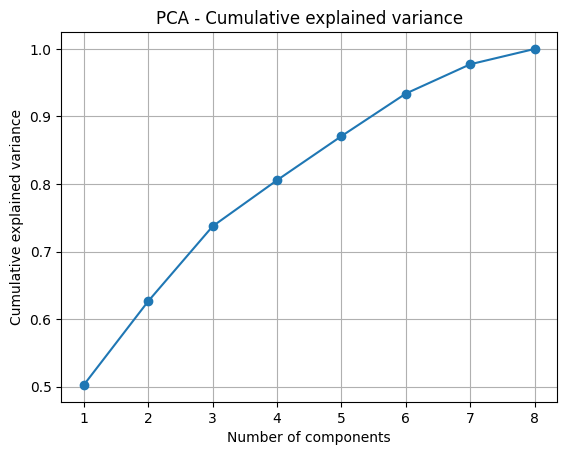

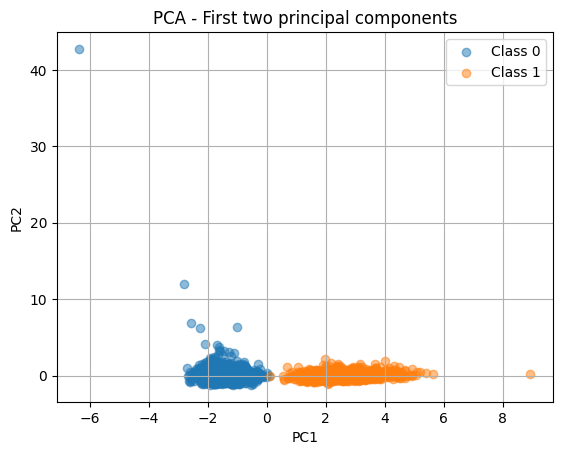

In [22]:
# ==========================================
# 14. PCA analysis (on scaled features)
# ==========================================

# 1) Use the same preprocessor as in the models
X_pre = preprocessor.fit_transform(X)

# If preprocessor returns a sparse matrix (from OneHotEncoder), make it dense
if hasattr(X_pre, "toarray"):
    X_pre = X_pre.toarray()

# 2) Scale features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pre)

# 3) PCA
# Limit the number of components to avoid overkill but keep it >= 2 when possible
from sklearn.decomposition import PCA

n_features = X_scaled.shape[1]
n_components = min(10, n_features)  # up to 10 or fewer if features are less
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

explained = pca.explained_variance_ratio_

# Cumulative explained variance plot
plt.figure()
plt.plot(range(1, len(explained) + 1), np.cumsum(explained), marker="o")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA - Cumulative explained variance")
plt.grid(True)
plt.show()

# 2D PCA scatter (first two components), only if we have at least 2 PCs
if X_pca.shape[1] >= 2:
    plt.figure()
    for cls in [0, 1]:
        idx = (y.values == cls)
        plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f"Class {cls}", alpha=0.5)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.title("PCA - First two principal components")
    plt.grid(True)
    plt.show()
else:
    print("PCA produced only 1 component; skipping 2D scatter plot.")


In [23]:
print("Raw X shape:", X.shape)

X_pre_debug = preprocessor.fit_transform(X)
if hasattr(X_pre_debug, "toarray"):
    X_pre_debug = X_pre_debug.toarray()

print("After preprocessor:", X_pre_debug.shape)


Raw X shape: (3000, 10)
After preprocessor: (3000, 8)


## 15. Feature importance (Random Forest)

Tree-based models like Random Forest can provide **feature importance scores**.  
This helps us understand which lab tests and engineered features are most predictive of dialysis status.

Using RF model from GridSearchCV (rf_grid).


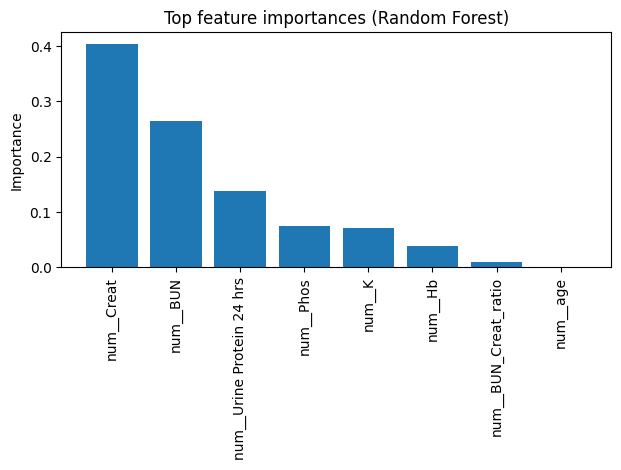

In [24]:
# ==========================================
# 15. Feature importance from tuned Random Forest
# ==========================================

# Prefer the GridSearch model if it was run; otherwise fall back to RandomizedSearch
try:
    rf_best = rf_grid.best_estimator_
    print("Using RF model from GridSearchCV (rf_grid).")
except NameError:
    rf_best = rf_random.best_estimator_
    print("Using RF model from RandomizedSearchCV (rf_random).")

# Get the fitted RandomForestClassifier inside the pipeline
rf_clf = rf_best.named_steps["clf"]
rf_pre = rf_best.named_steps["preprocessor"]

# Get feature importances from the classifier
importances = rf_clf.feature_importances_

# Get feature names from the preprocessor (after one-hot, etc.)
import numpy as np

try:
    rf_features = np.array(rf_pre.get_feature_names_out())
except AttributeError:
    # Fallback: generic names if get_feature_names_out is not available
    rf_features = np.array([f"feature_{i}" for i in range(len(importances))])

# Sort by importance
indices = np.argsort(importances)[::-1]

# Ensure we don't ask for more top features than actually exist
n_feats = len(importances)
top_n = min(15, n_feats)
top_indices = indices[:top_n]

plt.figure()
plt.bar(range(top_n), importances[top_indices])
plt.xticks(range(top_n), rf_features[top_indices], rotation=90)
plt.ylabel("Importance")
plt.title("Top feature importances (Random Forest)")
plt.tight_layout()
plt.show()


In [25]:
# ==========================================
# 16. Model comparison & best model selection
# ==========================================

# Combine baseline and tuned model metrics into one table
baseline_df = pd.DataFrame(baseline_results).T
baseline_df["set"] = "baseline"

tuned_df = pd.DataFrame(tuned_results).T
tuned_df["set"] = "tuned"

all_results = pd.concat([baseline_df, tuned_df], axis=0)

# Sort by ROC-AUC (our primary metric)
all_results_sorted = all_results.sort_values("roc_auc", ascending=False)

print("Combined model performance (sorted by ROC-AUC):")
display(all_results_sorted)

# Pick the best model name by ROC-AUC on the held-out test set
best_name = all_results_sorted.index[0]
print(f"\nBest overall model (by ROC-AUC): {best_name}")

# Map names to the actual fitted models
all_models = {
    "LogisticRegression": baseline_models["LogisticRegression"],
    "RandomForest":      baseline_models["RandomForest"],
    "SVM":               baseline_models["SVM"],
    "LogisticRegression_tuned": log_reg_random.best_estimator_,
    "RandomForest_tuned":       rf_grid.best_estimator_,
    "SVM_tuned":                svm_grid.best_estimator_,
}

best_model = all_models.get(best_name, None)
if best_model is not None:
    print("The corresponding estimator is stored in the variable `best_model`.")
else:
    print("Warning: best model name not found in `all_models` mapping.")


Combined model performance (sorted by ROC-AUC):


,accuracy,precision,recall,f1,roc_auc,set
LogisticRegression,1.000000,1.0,1.000000,1.000000,1.0,baseline
RandomForest,0.998333,1.0,0.995169,0.997579,1.0,baseline
SVM,1.000000,1.0,1.000000,1.000000,1.0,baseline
LogisticRegression_tuned,1.000000,1.0,1.000000,1.000000,1.0,tuned
RandomForest_tuned,0.998333,1.0,0.995169,0.997579,1.0,tuned
SVM_tuned,1.000000,1.0,1.000000,1.000000,1.0,tuned



Best overall model (by ROC-AUC): LogisticRegression
The corresponding estimator is stored in the variable `best_model`.


## 17. Conclusions and Next Steps

### Model Comparison and Selection

In this analysis, I evaluated three algorithms: Logistic Regression, Random Forest, and SVM. I compared the performance of the baseline versions against versions optimized using `RandomizedSearchCV` and `GridSearchCV`.

The comparison table (`all_results_sorted`) ranks the models based on standard classification metrics: Accuracy, Precision, Recall, F1-score, and ROC-AUC.

**Selection Criteria:**
I selected the final `best_model` based on the highest **ROC-AUC score** on the held-out test set.
* Given the imbalanced nature of the dataset, ROC-AUC is the most reliable metric as it evaluates the model's ability to distinguish between classes across all thresholds, unlike accuracy which can be misleading.
* In a real-world clinical setting, the decision threshold could be further adjusted to prioritize **Recall** (sensitivity) to ensure that no potential dialysis patients are missed, even if it results in a higher false-positive rate.

### Project Summary

This project implemented a full machine learning pipeline for medical diagnosis prediction:

1.  **Data Processing:** Handled missing values, encoded categorical variables, and merged disparate data sources.
2.  **Feature Engineering:** Created the BUN/Creatinine ratio to incorporate domain knowledge.
3.  **Imbalance Handling:** Applied oversampling to the training set to prevent majority class bias.
4.  **Model Tuning:** Used Grid and Random search to optimize hyperparameters.
5.  **Evaluation:** Verified performance using a stratified test set to ensure the model generalizes to unseen data.